In [1]:
# Load libraries
import os
import numpy as np
import cv2
import tensorflow as tf 
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, normalize

In [2]:
glioma = []
meninglioma = []
no_tumor = []
pitutary = []

glioma_path = 'image_dataset/Training/glioma_tumor/*.jpg'
meninglioma_path = 'image_dataset/Training/meningioma_tumor/*.jpg'
no_tumor_path = 'image_dataset/Training/no_tumor/*.jpg'
pitutary_path = 'image_dataset/Training/pituitary_tumor/*.jpg'

for f in glob.glob(glioma_path):
    img = cv2.imread(f)
    glioma.append(img)

for f in glob.glob(meninglioma_path):
    img = cv2.imread(f)
    meninglioma.append(img)

for f in glob.glob(no_tumor_path):
    img = cv2.imread(f)
    no_tumor.append(img)

for f in glob.glob(pitutary_path):
    img = cv2.imread(f)
    pitutary.append(img)

len(glioma), len(meninglioma), len(no_tumor), len(pitutary)


(826, 822, 395, 827)

In [3]:
glioma_test = []
meninglioma_test = []
no_tumor_test = []
pitutary_test = []

glioma_test_path = 'image_dataset/Training/glioma_tumor/*.jpg'
meninglioma_test_path = 'image_dataset/Training/meningioma_tumor/*.jpg'
no_tumor_test_path = 'image_dataset/Training/no_tumor/*.jpg'
pitutary_test_path = 'image_dataset/Training/pituitary_tumor/*.jpg'

for f in glob.glob(glioma_test_path):
    img = cv2.imread(f)
    glioma_test.append(img)

for f in glob.glob(meninglioma_test_path):
    img = cv2.imread(f)
    meninglioma_test.append(img)

for f in glob.glob(no_tumor_test_path):
    img = cv2.imread(f)
    no_tumor_test.append(img)

for f in glob.glob(pitutary_test_path):
    img = cv2.imread(f)
    pitutary_test.append(img)

len(glioma_test), len(meninglioma_test), len(no_tumor_test), len(pitutary_test)

(826, 822, 395, 827)

In [4]:
# Crop images

def crop_countour(images, plot = False):
    new_images = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh1 = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh1 = cv2.erode(thresh1, None, iterations=2)
        thresh1 = cv2.dilate(thresh1, None, iterations=2)

        contour = cv2.findContours(thresh1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = contour[0] if len(contour) == 2 else contour[1]
        c = max(contour, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

        if plot:
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(new_image)
            plt.title('Cropped Image')
            plt.axis('off')
            
        new_images.append(new_image)

    return new_images
    

In [5]:
# Resize all images to the target shape
glioma = crop_countour(glioma, plot = False)
meninglioma = crop_countour(meninglioma, plot = False)
no_tumor = crop_countour(no_tumor, plot = False)
pitutary = crop_countour(pitutary, plot = False)

glioma_test = crop_countour(glioma_test, plot = False)
meninglioma_test = crop_countour(meninglioma_test, plot = False)
no_tumor_test = crop_countour(no_tumor_test, plot = False)
pitutary_test = crop_countour(pitutary_test, plot = False)


In [6]:
# Define the target shape for resizing images
target_shape = (256, 256)

# Function to resize images
def resize_images(image_list, target_shape):
	resized_images = []
	for img in image_list:
		resized_img = cv2.resize(img, target_shape)
		resized_images.append(resized_img)
	return np.array(resized_images)


# Resize all images to the target shape
glioma = resize_images(glioma, target_shape)
meninglioma = resize_images(meninglioma, target_shape)
no_tumor = resize_images(no_tumor, target_shape)
pitutary = resize_images(pitutary, target_shape)

all_images = np.concatenate((glioma, meninglioma, no_tumor, pitutary), axis=0)

glioma_test = resize_images(glioma_test, target_shape)
meninglioma_test = resize_images(meninglioma_test, target_shape)
no_tumor_test = resize_images(no_tumor_test, target_shape)
pitutary_test = resize_images(pitutary_test, target_shape)

all_images_test = np.concatenate((glioma_test, meninglioma_test, no_tumor_test, pitutary_test), axis=0)

all_images.shape, all_images_test.shape

((2870, 256, 256, 3), (2870, 256, 256, 3))

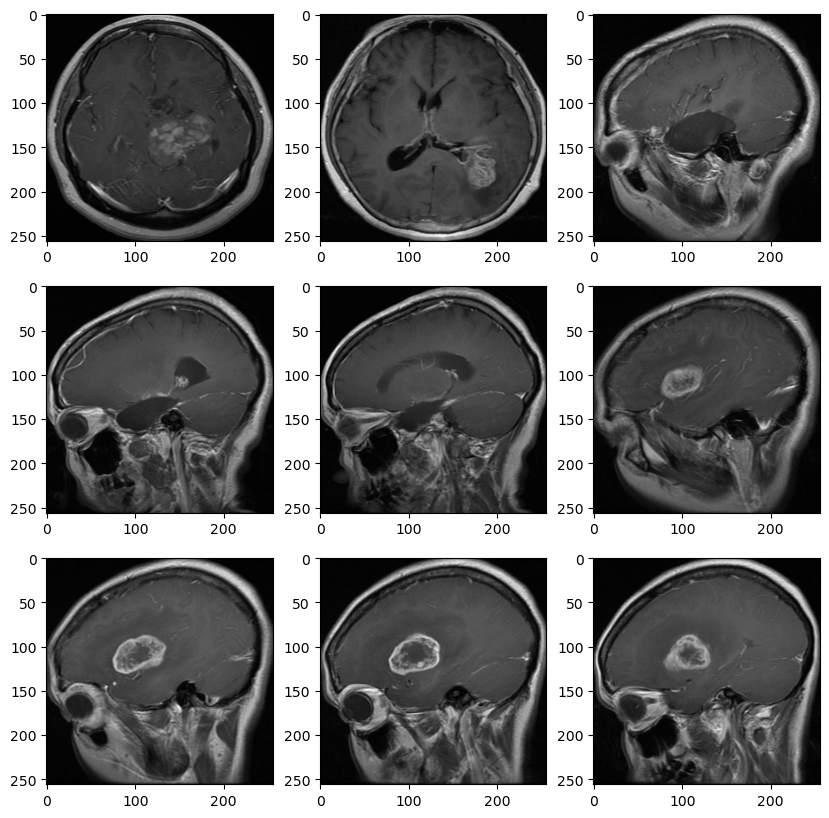

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images[i])

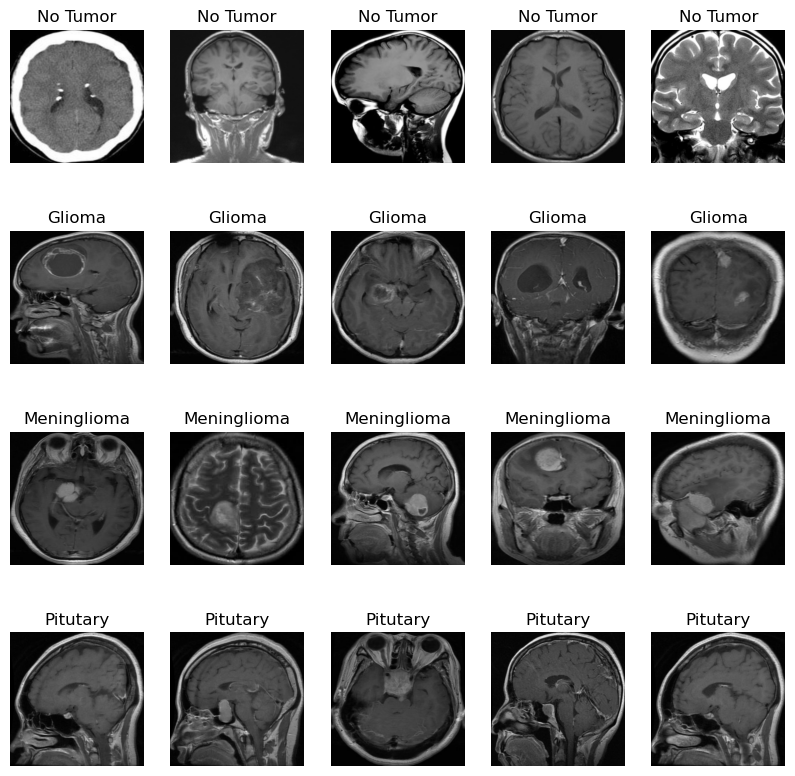

In [8]:
def plot_random(glioma, meninglioma, pitutary, no_tumor, num=5):
    healthy_img = no_tumor[np.random.choice(no_tumor.shape[0], num, replace=False)]
    glioma_img = glioma[np.random.choice(glioma.shape[0], num, replace=False)]
    meninglioma_img = meninglioma[np.random.choice(meninglioma.shape[0], num, replace=False)]
    pitutary_img = pitutary[np.random.choice(pitutary.shape[0], num, replace=False)]

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(4, num, i + 1)
        plt.imshow(healthy_img[i])
        plt.title('No Tumor')
        plt.axis('off')

        plt.subplot(4, num, i + num + 1)
        plt.imshow(glioma_img[i])
        plt.title('Glioma')
        plt.axis('off')

        plt.subplot(4, num, i + 2*num + 1)
        plt.imshow(meninglioma_img[i])
        plt.title('Meninglioma')
        plt.axis('off')

        plt.subplot(4, num, i + 3*num + 1)
        plt.imshow(pitutary_img[i])
        plt.title('Pitutary')
        plt.axis('off')

plot_random(glioma, meninglioma, pitutary, no_tumor)

In [9]:
# Define the dataset class
# The dataset class should inherit from torch.utils.data.Dataset
# The __init__ method should accept the data and labels as arguments
# The __len__ method should return the length of the dataset
# The __getitem__ method should return a dictionary containing the data and the label
# The normalize method should normalize the data
# label 0: glioma, label 1: meninglioma, label 2: pitutary, label 3: no_tumor

class MRIDataset(Dataset):
    def __init__(self, glioma, meninglioma, pitutary, no_tumor, transform=None):
        self.images = np.concatenate((glioma, meninglioma, pitutary, no_tumor), axis=0)
        self.labels = np.concatenate((
            np.zeros(len(glioma), dtype=float), 
            np.ones(len(meninglioma),dtype=float), 
            np.full(len(pitutary), 2, dtype=float), 
            np.full(len(no_tumor), 3, dtype=float)
        ), axis=0)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return {'image': image, 'label': label}

    def normalize(self):
        return normalize(self.images, axis=1)
    
    def to_categorical(self):
        return to_categorical(self.labels, num_classes=4)
    


In [10]:
# Create an instance of the dataset
dataset = MRIDataset(glioma, meninglioma, pitutary, no_tumor)
test_dataset = MRIDataset(glioma_test, meninglioma_test, pitutary_test, no_tumor_test)

len(dataset)

2870

In [11]:
dataset.normalize()  
test_dataset.normalize()

dataset.to_categorical()
test_dataset.to_categorical()

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [12]:
dataloader  = DataLoader(dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(dataset.images, dataset.labels, test_size=0.2, random_state=42, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2296, 256, 256, 3), (574, 256, 256, 3), (2296,), (574,))

In [14]:
#Model

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))


d:\Anaconda\envs\Tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=32, 
          validation_data=(X_val, y_val), 
          shuffle=False,
          callbacks=[ModelCheckpoint('model.h5', save_best_only=True)])